<a href="https://colab.research.google.com/github/joncarter1/GP-Regression/blob/master/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Function imports

In [58]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import warnings
warnings.filterwarnings("ignore")


import matplotlib
matplotlib.use('nbagg')
from GPy2.models import GaussianProcess, LookaheadGP
from GPy2.kernels import IsoSQEKernel, PeriodicKernel, QuadraticKernel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data provided 

1. Update Date and Time (ISO)
2. Update Duration (ms)
3. Reading Date and Time (ISO)
4. Air pressure (mb)
5. Air temperature (C) – A variable of interest.
6. Tide height (m) – Another variable of interest.
7. Wind direction (deg)
8. Wind gust speed (kn)
9. Wind speed (kn)
10. True air temperature (C) – Ground truth air temperature, against which you should compare your predictions.
11. True tide height (m) – Ground truth tide height, against which you should compare your predictions.
12. Independent tide height prediction (m) – These are some GP predictions prepared earlier for you to compare against, if you so choose.
13. Independent tide height deviation (m) – The standard deviation of the GP predictions above.
14. Dependent tide height prediction (m) – Another GP prediction built using three additional sensors not provided to you.
15. Dependent tide height deviation (m) – The standard deviation of the GP predictions above.
16. Independent air temperature prediction (C) – These are some GP predictions prepared earlier for you to compare against, if you so choose.
17. Independent air temperature deviation (C) – The standard deviation of the GP predictions above.
18. Dependent air temperature prediction (C) – Another GP prediction built using three additional sensors not provided to you.
19. Dependent air temperature deviation (C) – The standard deviation of the GP predictions above.

# Loading and pre-processing weather data

In [59]:
from data import *

# Variables for prediction

<IPython.core.display.Javascript object>


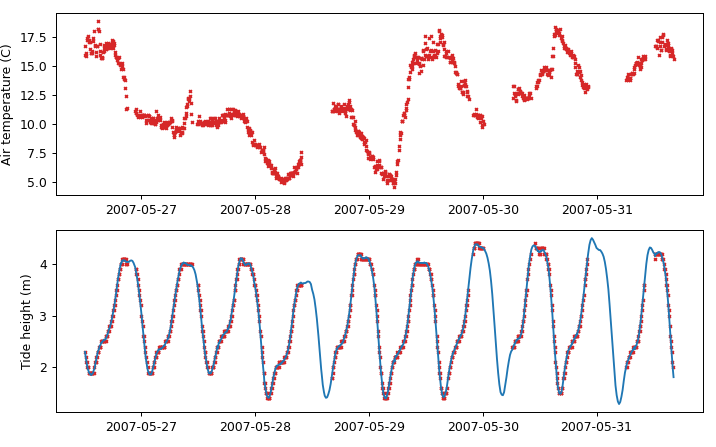

In [60]:
target_cols = [4, 5]
fig, ax = plt.subplots(len(target_cols), 1, figsize=(8,5))
column_plotter(weather_data, target_cols, ax)
ax[1].plot(all_reading_times, true_tide_heights)
plt.show()

Remarks
- Clear periodic trend in tide (~12.5hr period)
- Amplitude varies fairly smoothly over about a day
- Distinct bumps at high tide and low-mid tide

# Fitting Gaussian Process models

In [61]:
import torch
import numpy as np
# Fixing seeds for re-producibility
torch.random.manual_seed(1)
np.random.seed(1)
from evaluation import gp_inference  # Function for optimising, plotting and evaluating GP metrics

## 1. Isotropic exponentiated quadratic (IsoSQE) GP model

Prior to optimisation:



  0%|          | 0/50 [00:00<?, ?it/s]

Marginal LL : tensor([[1273.5429]], dtype=torch.float64, grad_fn=<NegBackward>)
Test data LL : tensor([[4.0019]], dtype=torch.float64)
Test data rmse : 0.16191513881814398
Old hyper-parameters: tensor([74.5000,  2.0000], dtype=torch.float64, grad_fn=<ExpBackward>)


100%|██████████| 50/50 [00:14<00:00,  3.40it/s]


New hyper-parameters: tensor([78.2839,  1.9034], dtype=torch.float64, grad_fn=<ExpBackward>)
Negative log-likelihood : tensor([[-1288.5981]], dtype=torch.float64, grad_fn=<MulBackward0>)
After optimisation:

Marginal LL : tensor([[1288.8885]], dtype=torch.float64, grad_fn=<NegBackward>)
Test data LL : tensor([[4.0042]], dtype=torch.float64)
Test data rmse : 0.15673020867349824


<IPython.core.display.Javascript object>


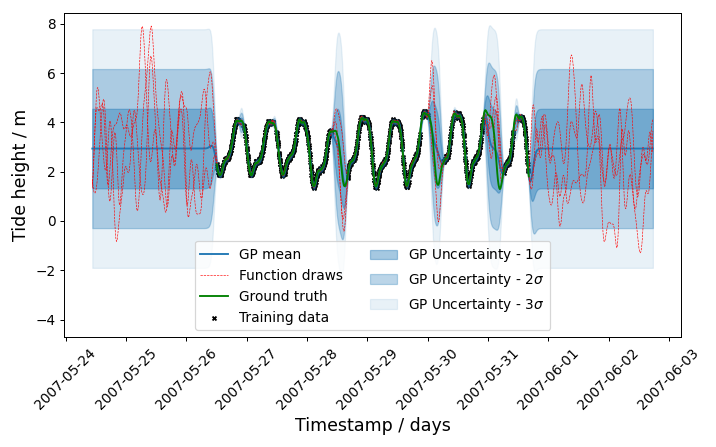

In [62]:
period = 60*12 + 25  # Exact tidal period about 12h and 25 mins
iso_params = torch.tensor(np.log([period/10, 2]), requires_grad=True)
iso = IsoSQEKernel(iso_params)
optimised_iso_gp = gp_inference(iso, 50, sigma_n=sigma_n, lr=1e-3, jitter=1e-2)

## 2. Periodic GP model

Prior to optimisation:



  0%|          | 0/50 [00:00<?, ?it/s]

Marginal LL : tensor([[-5318.5975]], dtype=torch.float64, grad_fn=<NegBackward>)
Test data LL : tensor([[-1867.0313]], dtype=torch.float64)
Test data rmse : 0.6156045103318061
Old hyper-parameters: tensor([ 10.0000,   2.0000, 775.0000], dtype=torch.float64,
       grad_fn=<ExpBackward>)


100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


New hyper-parameters: tensor([  9.4502,   2.1159, 742.7188], dtype=torch.float64,
       grad_fn=<ExpBackward>)
Negative log-likelihood : tensor([[-223.6512]], dtype=torch.float64, grad_fn=<MulBackward0>)
After optimisation:

Marginal LL : tensor([[227.3714]], dtype=torch.float64, grad_fn=<NegBackward>)
Test data LL : tensor([[-204.0849]], dtype=torch.float64)
Test data rmse : 0.23930484937765084


<IPython.core.display.Javascript object>


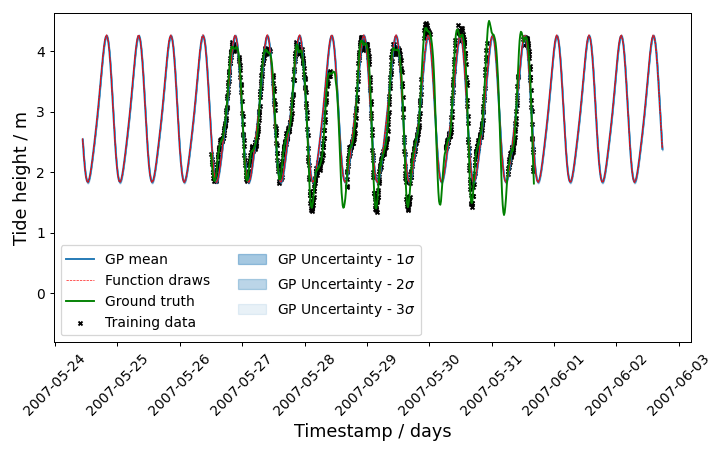

In [ ]:
period = 60*12 + 55  # Exact tidal period about 12h and 25 mins (deliberately over-estimating)

periodic_params = torch.tensor(np.log([10, 2, period]), requires_grad=True)
periodic = PeriodicKernel(periodic_params)

gp_inference(periodic, 50, sigma_n=sigma_n, lr=1e-3, jitter=1e-2)

## 3. Composite GP model (periodic + periodic * RQ covariance)

Prior to optimisation:



  0%|          | 0/50 [00:00<?, ?it/s]

Marginal LL : tensor([[1399.5963]], dtype=torch.float64, grad_fn=<NegBackward>)
Test data LL : tensor([[3.1380]], dtype=torch.float64)
Test data rmse : 0.07329190963589496
Old hyper-parameters: tensor([7.4500e+02, 5.0000e-01, 1.0000e+00], dtype=torch.float64,
       grad_fn=<ExpBackward>)tensor([5.0000e-01, 5.0000e-01, 1.4900e+03], dtype=torch.float64,
       grad_fn=<ExpBackward>)tensor([5.0000e-01, 5.0000e-01, 1.4900e+03], dtype=torch.float64,
       grad_fn=<ExpBackward>)


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


New hyper-parameters: tensor([7.8387e+02, 4.9936e-01, 9.5013e-01], dtype=torch.float64,
       grad_fn=<ExpBackward>)tensor([4.6049e-01, 5.4432e-01, 1.4844e+03], dtype=torch.float64,
       grad_fn=<ExpBackward>)tensor([4.6049e-01, 5.4432e-01, 1.4844e+03], dtype=torch.float64,
       grad_fn=<ExpBackward>)
Negative log-likelihood : tensor([[-1419.0475]], dtype=torch.float64, grad_fn=<MulBackward0>)
After optimisation:

Marginal LL : tensor([[1419.1710]], dtype=torch.float64, grad_fn=<NegBackward>)
Test data LL : tensor([[3.5200]], dtype=torch.float64)
Test data rmse : 0.04860127843790267


<IPython.core.display.Javascript object>


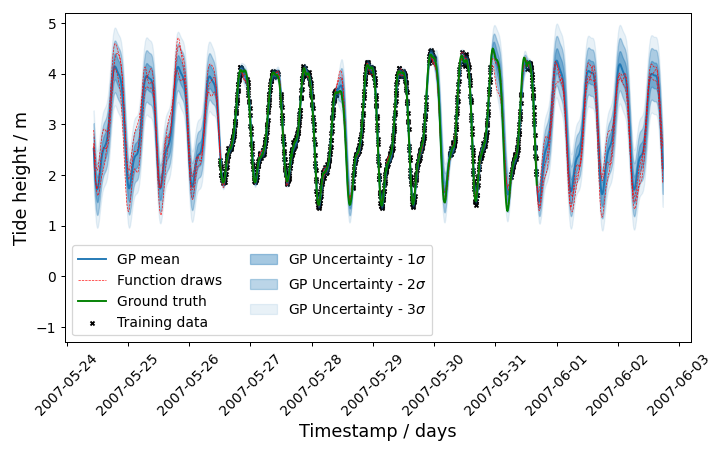

In [ ]:
period = 2*(12*60 + 25)

periodic_params = torch.tensor(np.log([0.5, 0.5, period]), requires_grad=True)
periodic_kernel = PeriodicKernel(periodic_params)

quadratic_params = torch.tensor(np.log([period/2, .5, 1]), requires_grad=True)
rq_kernel = QuadraticKernel(quadratic_params, 2)

combined_kernel = rq_kernel*periodic_kernel + periodic_kernel

optimised_gp = gp_inference(combined_kernel, 50, sigma_n=sigma_n, jitter=1e-2, lr=1e-3)

# Lookahead inference using GPs

## Using Iso SQE Kernel

In [ ]:
optimised_iso_kernel = optimised_iso_gp.covar_kernel

iso_lookahead_gp = LookaheadGP(covar_kernel=optimised_iso_kernel, sigma_n=sigma_n, training_data=scaled_reading_times, 
                          labels=scaled_tide_heights, learn_noise=False)

lookahead = 60  # 1 hour lookahead prediction (useful as a surfer!)
t_predictions = torch.linspace(0, 7500, 100)

iso_l_means, iso_l_vars = iso_lookahead_gp.compute_lookahead_predictive_means_vars(t_predictions, lookahead)
iso_lookahead_means, iso_lookahead_vars = iht(iso_l_means), (tide_std**2)*iso_l_vars

100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


<IPython.core.display.Javascript object>


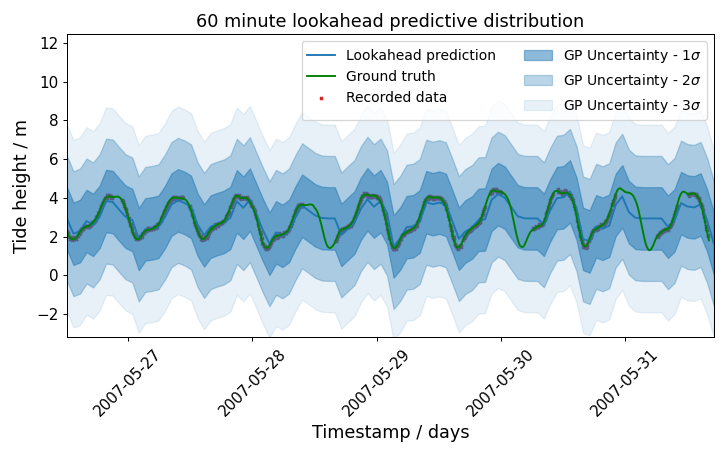

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(reading_times, tide_heights, s=5, marker="x", label="Recorded data", color="tab:red")
#plt.plot(sample_times, sample_means, color="tab:blue", label="GP mean"
plt.title(f"{lookahead} minute lookahead predictive distribution", fontsize=14)
plt.plot(itt(t_predictions), iso_lookahead_means, label="Lookahead prediction")
sigma_vector = np.diag(iso_lookahead_vars)**0.5

alphas = [0.5, 0.3, 0.1]
for i in range(3):
    j = i + 1
    plt.fill_between(itt(t_predictions), iso_lookahead_means-j*sigma_vector, iso_lookahead_means+j*sigma_vector,
                    alpha=alphas[i], color="tab:blue", label=fr"GP Uncertainty - ${i+1}\sigma$")

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(plt.ylim()[0]-2)
plt.ylabel("Tide height / m", fontsize=14)
plt.xlabel("Timestamp / days", fontsize=14)
plt.ylabel("Tide height / m")
plt.xlabel("Timestamp / days")
plt.plot(all_reading_times, true_tide_heights, label="Ground truth", color="green")
plt.legend(fontsize=11, ncol=2)
plt.tight_layout()
plt.show()

## Using optimised Periodic*(1+RQ) Kernel

In [ ]:
optimised_kernel = optimised_gp.covar_kernel

combined_lookahead_gp = LookaheadGP(covar_kernel=optimised_kernel, sigma_n=sigma_n, training_data=scaled_reading_times, 
                          labels=scaled_tide_heights, learn_noise=False)

lookahead = 60
#t_predictions = torch.linspace(lookahead, 7500, 200)
lookahead_means, lookahead_vars = combined_lookahead_gp.compute_lookahead_predictive_means_vars(scaled_all_reading_times, lookahead)
lookahead_means, lookahead_vars = iht(lookahead_means), (tide_std**2)*lookahead_vars

100%|██████████| 200/200 [00:19<00:00, 10.02it/s]


<IPython.core.display.Javascript object>


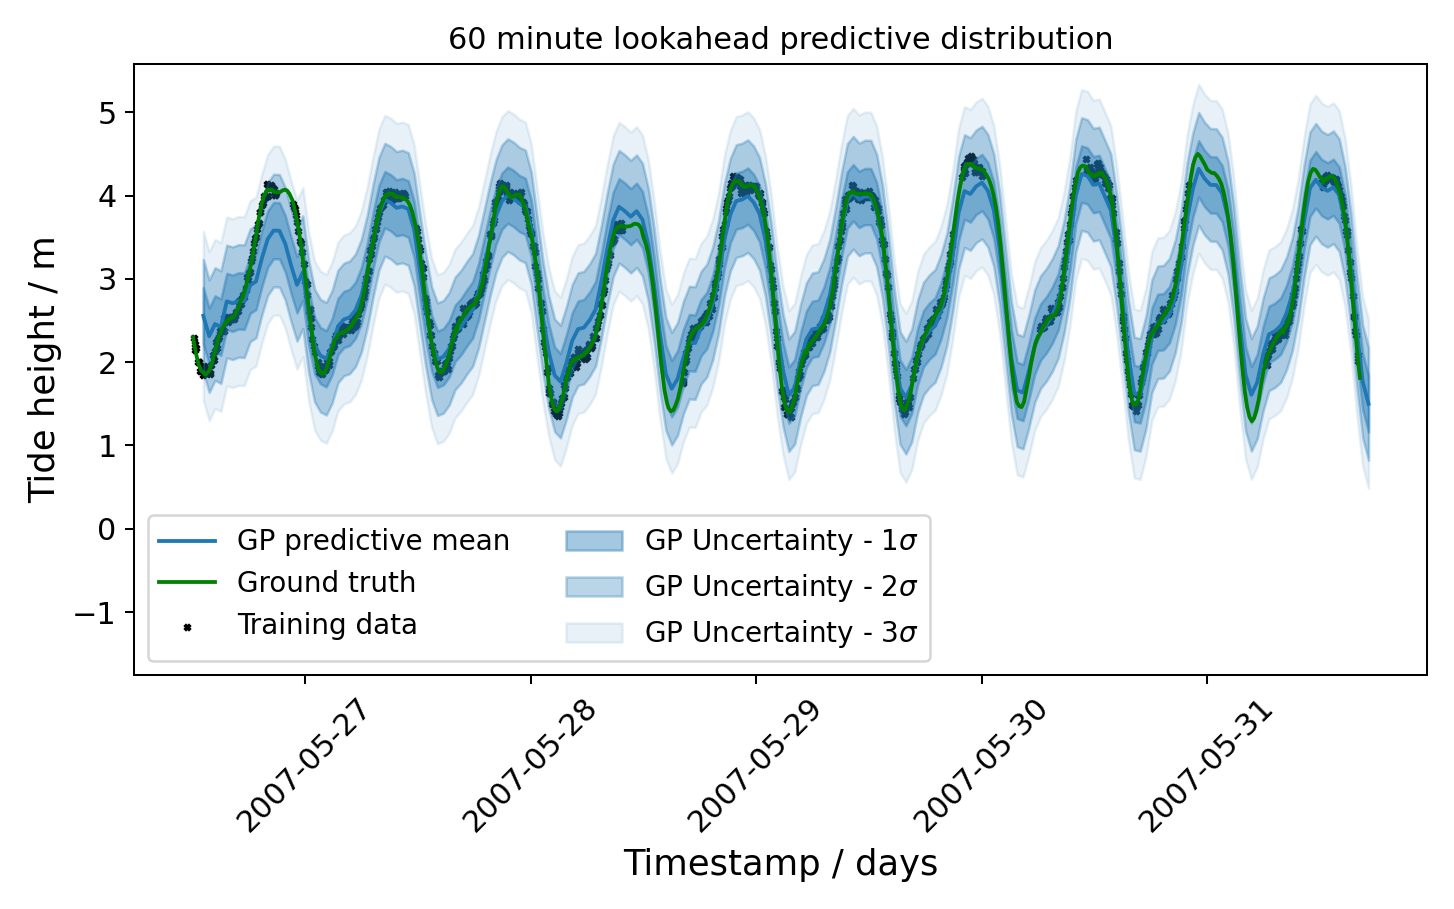

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(reading_times, tide_heights, s=5, marker="x", label="Training data", color="black")
#plt.plot(sample_times, sample_means, color="tab:blue", label="GP mean"

plt.title(f"{lookahead} minute lookahead predictive distribution")
plt.plot(itt(t_predictions), lookahead_means, label="GP predictive mean")
sigma_vector = np.diag(lookahead_vars)**0.5

alphas = [0.4, 0.3, 0.1]
for i in range(3):
    j = i + 1
    plt.fill_between(itt(t_predictions), lookahead_means-j*sigma_vector, lookahead_means+j*sigma_vector,
                    alpha=alphas[i], color="tab:blue", label=fr"GP Uncertainty - ${i+1}\sigma$")

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(plt.ylim()[0]-2)
plt.ylabel("Tide height / m", fontsize=14)
plt.xlabel("Timestamp / days", fontsize=14)
plt.plot(all_reading_times, true_tide_heights, label="Ground truth", color="green")
plt.legend(fontsize=11, ncol=2)
plt.tight_layout()
#plt.savefig("lookahead")
plt.show()